In [1]:
import numpy as np
import pandas as pd

from IPython.display import Image 
from matplotlib import pyplot as plt

# 3. Перевод слова в вектор

#### Каждое слово - вектор в некотором пространстве. Наша задача - найти наилучшее пространтсво векторов.

## Хотелка: чтобы векторное расстояние между похожими по смыслу словами было меньше, чем между не похожими. 



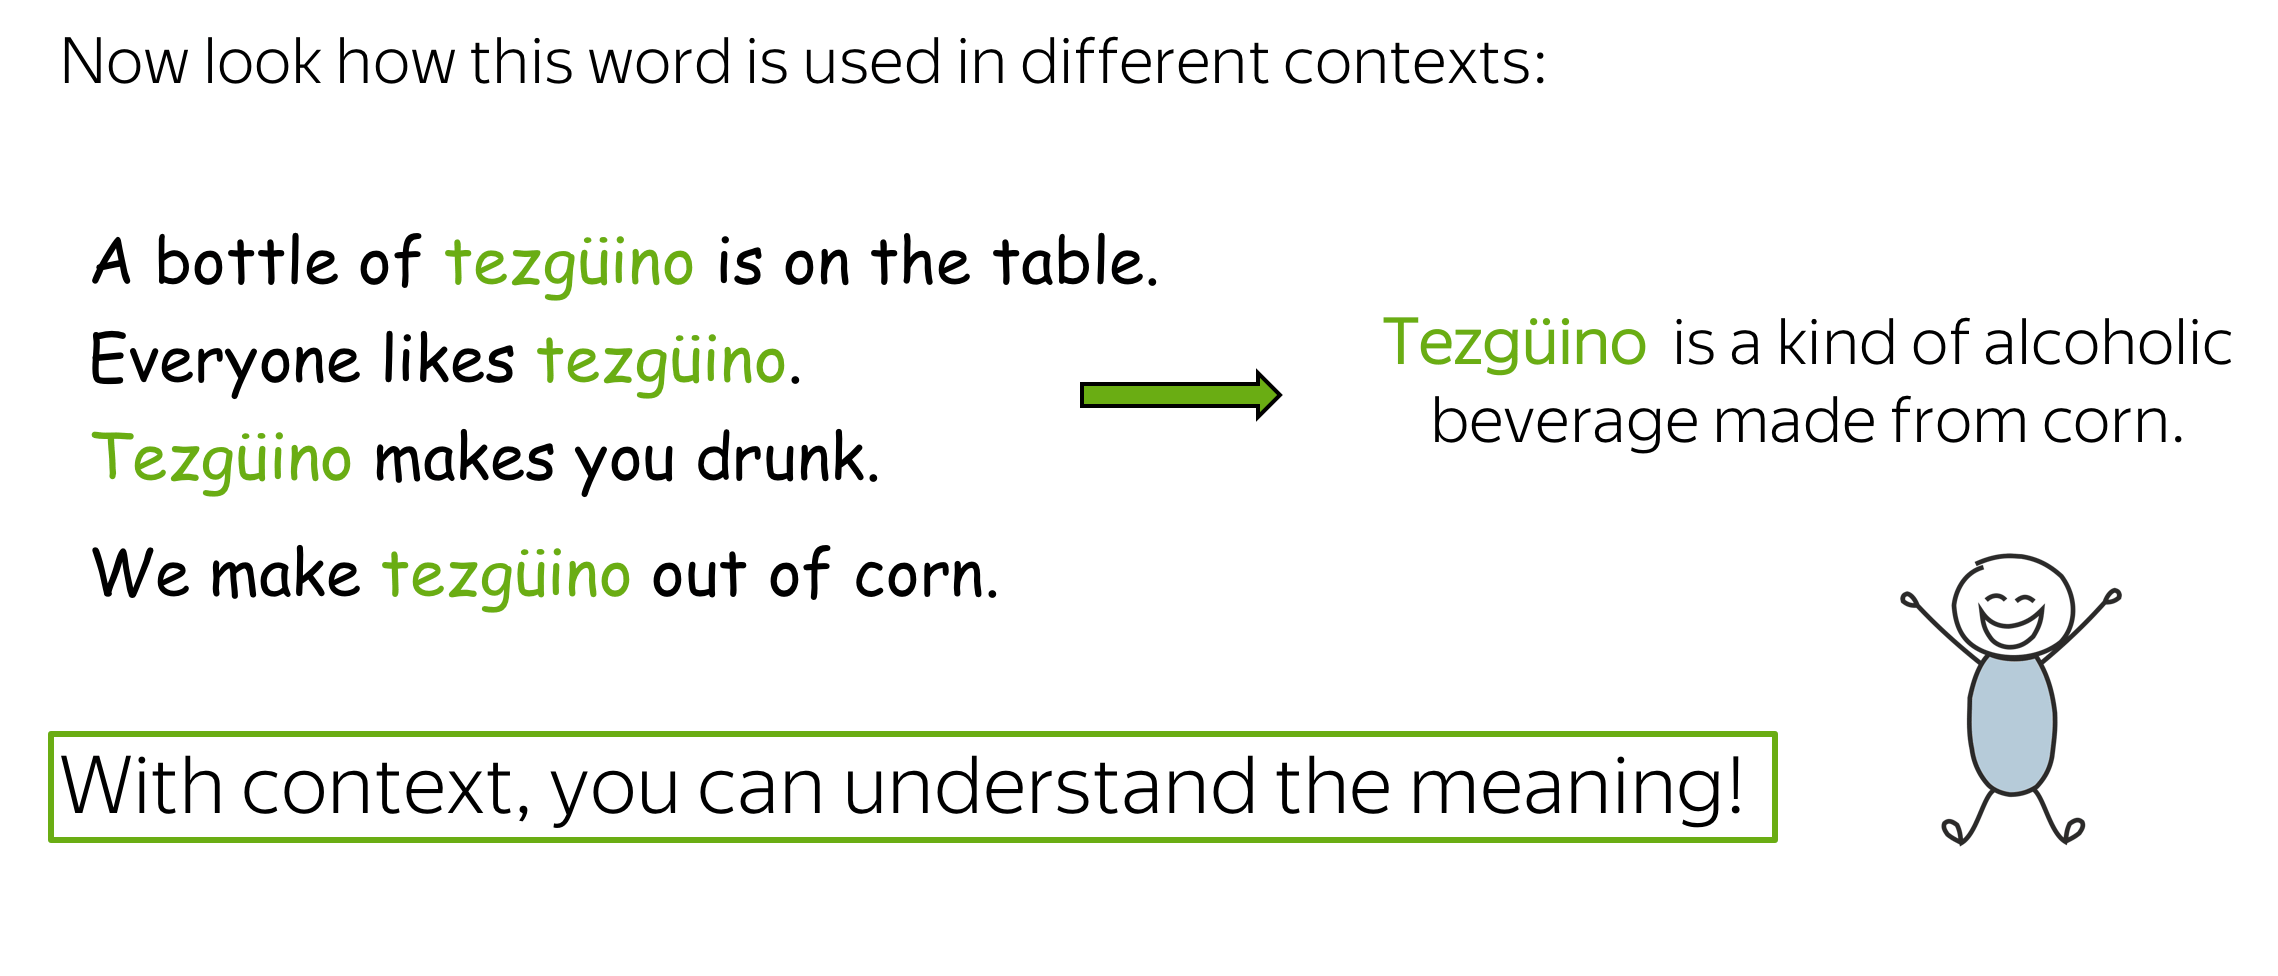

In [2]:
Image('images/tezguino2-min.png', width=600)

Image('images/tezguino3-min.png', width=600)

## 3.1 Co-occurrence counts

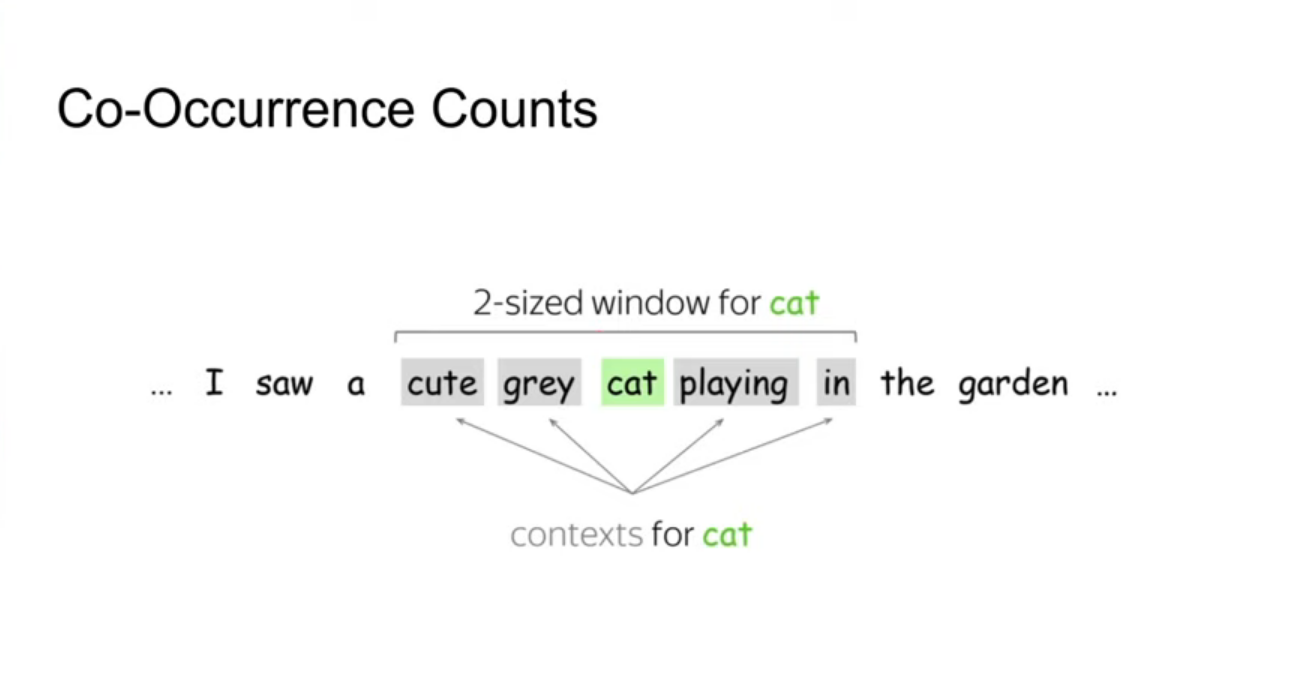

In [3]:
Image('images/co-occurence.png', width=600)

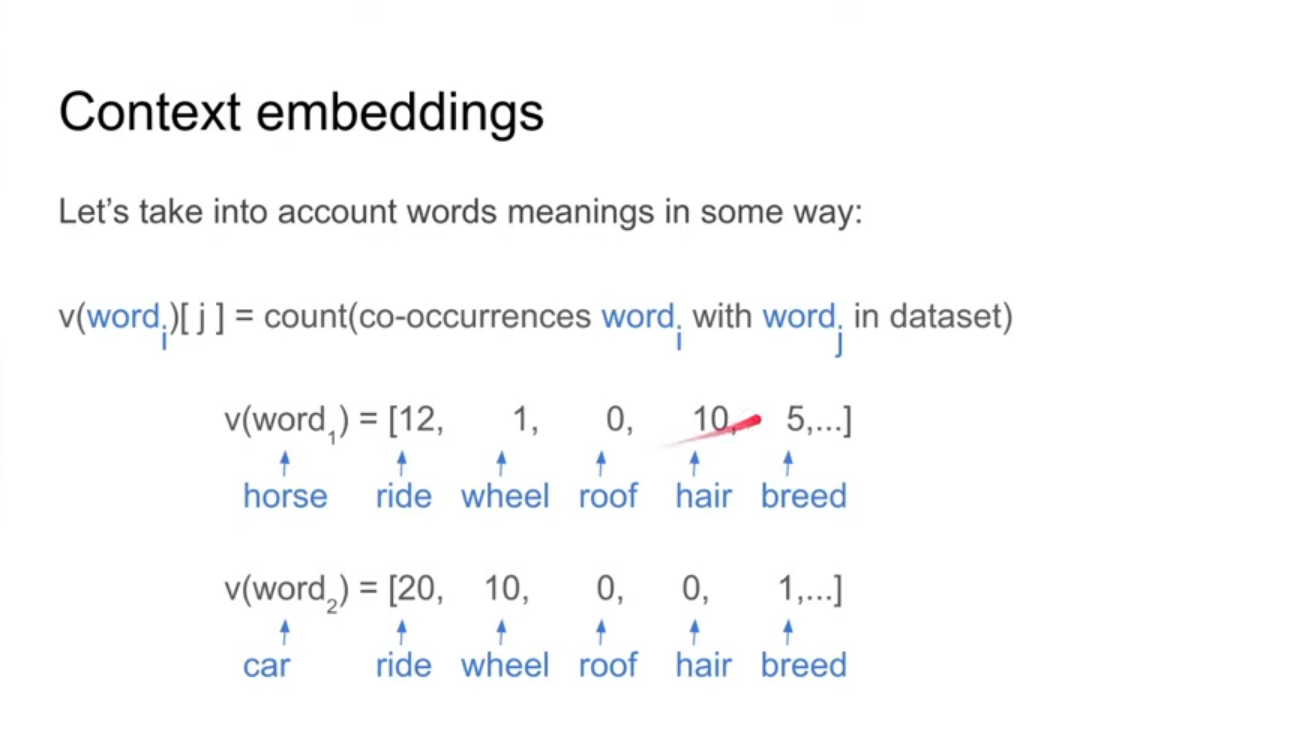

In [4]:
Image('images/context_embeddings.png', width=600)

Сделаем co-occurence для примера. У нас есть 3 предложения и окно длины 3 (одно слово до, по центру и после) 

In [71]:
X = ['I enjoy flying',
     'I like trains ',
     'I like taxi']

coocc = pd.DataFrame(
             index   = ['I', 'enjoy', 'like', 'flying', 'trains', 'taxi'],
             columns = ['I', 'enjoy', 'like', 'flying', 'trains', 'taxi'],
             data = np.array([[0, 1, 2, 0, 0, 0],
                              [1, 0, 0, 1, 0, 0],
                              [2, 0, 0, 0, 1, 1],
                              [0, 1, 0, 0, 0, 0],
                              [0, 0, 1, 0, 0, 0],
                              [0, 0, 1, 0, 0, 0]]))

In [72]:
coocc

I  enjoy  like  flying  trains  taxi
I       0      1     2       0       0     0
enjoy   1      0     0       1       0     0
like    2      0     0       0       1     1
flying  0      1     0       0       0     0
trains  0      0     1       0       0     0
taxi    0      0     1       0       0     0

Слова с идентичными контекстами имеют одинаковые вектора.

Однако понятно, что при очень большом словаре, мы получим матрицу гигантских размеров, которую неудобно хранить. Поэтому воспользуемся SVD разложением, чтобы уменьшить размер словаря.

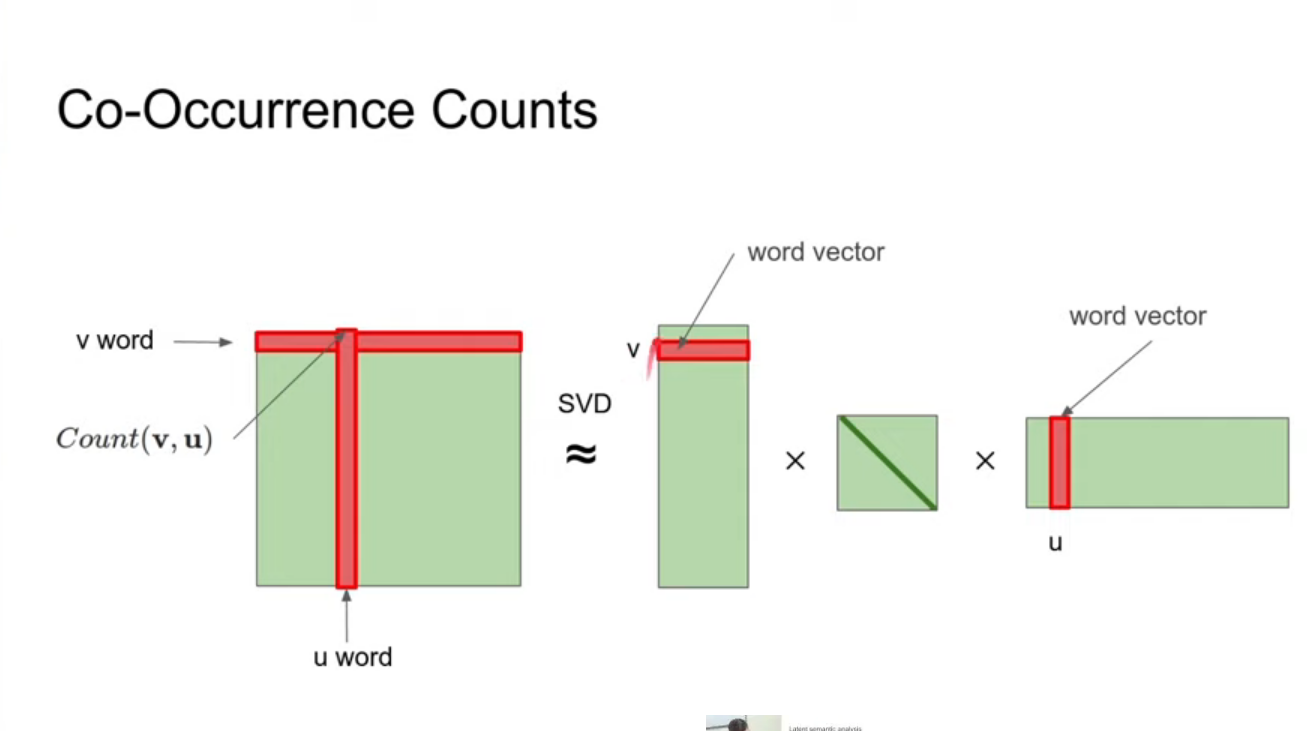

In [73]:
Image('images/SVD.png', width=600)

In [74]:
u, s, vh = np.linalg.svd(coocc)

In [75]:
s

array([2.61312593e+00, 2.61312593e+00, 1.08239220e+00, 1.08239220e+00,
       8.10371908e-17, 5.47284008e-33])

In [108]:
U = np.round(u,3)[:,:4]
S = np.eye(4) * s[:4]
VT = np.round(vh,3)[:4,:]

In [109]:
print(U.shape, coocc.shape)
U

(6, 4) (6, 6)


array([[ 0.854,  0.   , -0.   ,  0.146],
       [-0.   , -0.383, -0.924,  0.   ],
       [ 0.   , -0.924,  0.383, -0.   ],
       [ 0.146,  0.   , -0.   ,  0.854],
       [ 0.354,  0.   , -0.   , -0.354],
       [ 0.354,  0.   , -0.   , -0.354]])

In [110]:
np.round(U.dot(S).dot(VT), 1)

array([[ 0.,  1.,  2.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  1.,  0.,  0.],
       [ 2.,  0.,  0., -0.,  1.,  1.],
       [ 0.,  1., -0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.]])

In [111]:
np.abs(coocc - np.round(U.dot(S).dot(VT), 1))

I  enjoy  like  flying  trains  taxi
I       0.0    0.0   0.0     0.0     0.0   0.0
enjoy   0.0    0.0   0.0     0.0     0.0   0.0
like    0.0    0.0   0.0     0.0     0.0   0.0
flying  0.0    0.0   0.0     0.0     0.0   0.0
trains  0.0    0.0   0.0     0.0     0.0   0.0
taxi    0.0    0.0   0.0     0.0     0.0   0.0

Заметим, что у схожих слов и после сокращения размерностей вектора похожи.

In [112]:
from scipy.spatial.distance import cosine

In [113]:
cosine(U[3], U[4]), cosine(coocc['flying'], coocc['trains'])

(1.5778361689253098, 1.0)

In [114]:
cosine(U[4], U[5]), cosine(coocc['trains'], coocc['taxi'])

(0, 0)

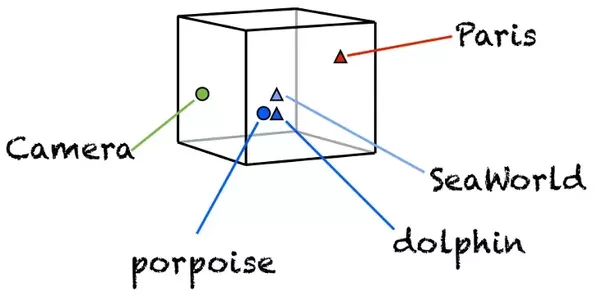

In [115]:
Image('images/embspace.png')

## 3.2 Word2Vec (обобщение контекстных эмбеддингов)

Эта секция будет изложена по соответствующей главе книги "Глубокое обучение" за авторством Сергея Николенко. В качестве основного источника дополнительной информации лучше брать не оригинальную публикацию про Word2Vec, а её разъяснение, появившееся позже. Так и называется, [word2vec Explained](https://arxiv.org/abs/1402.3722)

Эта модель стала первым способом выучивать для слов некоторые представления фиксированной размерности, в арифметических действиях над которыми прослеживалась некоторая языковая семантика. Word2Vec существует в двух ипостасях: skip-gram, когда мы хотим предсказать контекст слова по самому слову, и Continuous Bag Of Words, когда мы хотим предсказать слово по контексту. Само предсказание делается моделью, очень похожей на нейронную сеть; вообще, по сути word2vec —
это нейронная сеть, но неглубокая нейронная сеть, с одним скрытым слоем.

<img src="images/word2vec.png" width=800></img>

Каждый вход сети — это вектор в one-hot представлении размерности V, где V — размер словаря. Далее будем рассматривать skip-gram модель, хотя аналогичные рассуждения можно провести и для CBOW
* скрытый слой сети — это фактически и есть матрица W векторных представлений слов; n-я строка W содержит представление n-го слова из словаря;
* при вычислении выхода скрытого слоя мы берем просто среднее всех входных векторов; такая простота модели важна для того, чтобы в результате в пространстве представлений соотношения между векторами слов были тоже как можно проще
* на выходе получается некая оценка для каждого слова в словаре; затем апостериорное распределение модели вычисляется с помощью обычного softmax:

$$\Large{p(c \mid w ; \theta)=\frac{e^{v_c \cdot v_w}}{\sum_{c^{\prime} \in C} e^{v_{c^{\prime}} \cdot v_w}}}$$

* таким образом, функция потери на одном окне состоит в том, чтобы сделать апостериорное распределение как можно более похожим на распределение данных:

$$\Large{\arg \max _\theta \sum_{(w, c) \in D} \log p(c \mid w)=\sum_{(w, c) \in D}\left(\log e^{v_c \cdot v_w}-\log \sum_{c^{\prime}} e^{v_{c^{\prime}} \cdot v_w}\right)}$$

Слагаемое $ \Large{\sum_{c^{\prime}} e^{v_{c^{\prime}} \cdot v_w}}$ - страшное, т.к. суммирование предполагается по всевозможным контекстам, их очень-очень много. Попытаемся подменить задачу, чтобы по-прежнему вектор слова был близок к вектору его контекста, и далёк от других контекстов, но огромной суммы чтобы не было. 

Давайте будем пытаться считать некий "скор" D для данных слова и контекста, чтобы D было близко к 1, если слово действительно встречается в контексте, и к 0 иначе:

$$\large\begin{aligned}
& \arg \max _\theta \prod_{(w, c) \in D} p(D=1 \mid w, c ; \theta) \\
= & \arg \max _\theta \log \prod_{(w, c) \in D} p(D=1 \mid w, c ; \theta) \\
= & \arg \max _\theta \sum_{(w, c) \in D} \log p(D=1 \mid w, c ; \theta)
\end{aligned}$$


А сам скор считать будем так:

$$\large{p(D=1 \mid w, c ; \theta)=\frac{1}{1+e^{-v_c \cdot v_w}}}$$

Проблема. Если бы будем учить какой-то скор, показывая ему только примеры, где правильный ответ - это 1, мы выучим что-то бессмысленное. Решение - negative sampling. Давайте иногда закидывать слово в вообще случайный контекст и требовать выдавать на этом скор 0:

$$\large\begin{aligned}
& \arg \max _\theta \prod_{(w, c) \in D} p(D=1 \mid c, w ; \theta) \prod_{(w, c) \in D^{\prime}} p(D=0 \mid c, w ; \theta) \\
= & \arg \max _\theta \prod_{(w, c) \in D} p(D=1 \mid c, w ; \theta) \prod_{(w, c) \in D^{\prime}}(1-p(D=1 \mid c, w ; \theta)) \\
= & \arg \max _\theta \sum_{(w, c) \in D} \log p(D=1 \mid c, w ; \theta)+\sum_{(w, c) \in D^{\prime}} \log (1-p(D=1 \mid w, c ; \theta)) \\
= & \arg \max _\theta \sum_{(w, c) \in D} \log \frac{1}{1+e^{-v_c \cdot v_w}}+\sum_{(w, c) \in D^{\prime}} \log \left(1-\frac{1}{1+e^{-v_c \cdot v_w}}\right) \\
= & \arg \max _\theta \sum_{(w, c) \in D} \log \frac{1}{1+e^{-v_c \cdot v_w}}+\sum_{(w, c) \in D^{\prime}} \log \left(\frac{1}{1+e^{v_c \cdot v_w}}\right)
\end{aligned}$$

### Пример обучения word2vec

In [19]:
# токенизация
from nltk.tokenize import WordPunctTokenizer
data = list(open("data/quora.txt", encoding="utf-8")) # список вопросов с quora
tokenizer = WordPunctTokenizer()
data_tok = [tokenizer.tokenize(s.lower()) for s in data]
data_tok[4]

['why',
 'was',
 'george',
 'rr',
 'martin',
 'critical',
 'of',
 'jk',
 'rowling',
 'after',
 'losing',
 'the',
 'hugo',
 'award',
 '?']

In [20]:
# !pip install gensim
from gensim.models import Word2Vec

model = Word2Vec(data_tok, 
                 vector_size=10,      # embedding vector size
                 min_count=5,  # consider words that occured at least 5 times
                 window=5).wv  # define context as a 5-word window around the target word

In [21]:
model.get_vector('king')

array([ 2.7493806 , -4.4316883 ,  2.1097698 ,  0.82143265, -3.271395  ,
        0.43357676,  1.3093504 , -1.956049  , -1.1105144 , -1.9734617 ],
      dtype=float32)

In [22]:
model.most_similar('prince')

[('severus', 0.9823256731033325),
 ('albert', 0.9706840515136719),
 ('assange', 0.9587210416793823),
 ('darth', 0.958290696144104),
 ('paul', 0.9561535716056824),
 ('bruce', 0.9558662176132202),
 ('stark', 0.9556440711021423),
 ('ali', 0.9543253183364868),
 ('skywalker', 0.9518976807594299),
 ('krishna', 0.9515389800071716)]

In [23]:
from scipy.spatial.distance import cosine

cosine(model.get_vector('king'), model.get_vector('prince'))

0.0632635168431449

In [24]:
cosine(model.get_vector('king'), model.get_vector('queen'))

0.08233358601654805

In [25]:
cosine(model.get_vector('king'), model.get_vector('man')), cosine(model.get_vector('king'), model.get_vector('woman'))

(0.5124103424483989, 0.6526544492180081)

In [26]:
cosine(model.get_vector('king'), model.get_vector('horse'))

0.9983700045689189

### Большой предобученный Word2Vec

In [27]:
import gensim.downloader as api
model_twitter = api.load("glove-twitter-100") # предобученная модель на твитах

Можно делать так

In [28]:
model_twitter.get_vector('king')

array([-3.7500e-01, -2.7532e-01,  1.2489e-01, -9.2143e-02, -4.3104e-01,
        2.5268e-02, -4.1867e-02,  1.2848e-01, -7.9363e-02, -1.0011e-01,
        1.4076e-01,  1.0922e-01, -3.4546e+00, -6.9851e-01,  6.6580e-01,
        5.1494e-01,  4.5912e-01, -2.1957e-01,  4.4094e-01, -3.0631e-01,
        1.2293e-01, -9.9830e-02, -2.5755e-01, -6.1872e-01,  1.0613e+00,
       -9.4278e-01,  1.9284e-01, -8.2089e-02,  2.7782e-01, -1.8595e-01,
        2.9140e-02, -3.0870e-01, -3.9870e-01, -4.3038e-01,  3.8403e-01,
        3.3243e-01, -1.4446e-01,  1.6682e-01,  4.2301e-01, -2.6490e-01,
       -7.8106e-02, -4.6756e-01, -3.4039e-01, -1.3690e-01,  7.0890e-01,
       -4.8015e-01,  8.9183e-02, -2.3709e-01,  7.5124e-01,  2.0507e-01,
       -5.5263e-01, -3.8105e-01, -7.7082e-02,  3.6118e-01, -8.9840e-01,
       -5.3537e-01,  3.3161e-01, -1.3460e-01, -5.7742e-02,  1.9428e-01,
        1.8008e-01, -4.0697e-01,  2.6654e-03, -7.8771e-02, -2.3616e-01,
       -9.8115e-01, -1.6823e-01,  1.1459e-01, -2.7011e-01, -2.14

In [29]:
model_twitter.most_similar('muse')

[('coldplay', 0.8080717921257019),
 ('paramore', 0.7668759822845459),
 ('metallica', 0.7606366872787476),
 ('oasis', 0.7555792927742004),
 ('linkin', 0.7516505122184753),
 ('beatles', 0.7458094954490662),
 ('nirvana', 0.7320070266723633),
 ('aerosmith', 0.7288547158241272),
 ('maroon', 0.7187884449958801),
 ('radiohead', 0.7150725722312927)]

А можно вот так

In [30]:
model_twitter.most_similar(positive=["trump", "white"], negative=['black'])

[('donald', 0.6632781028747559),
 ('buffett', 0.6340493559837341),
 ('birther', 0.6288853287696838),
 ('christie', 0.5956118106842041),
 ('bloomberg', 0.5855364799499512),
 ('rogers', 0.5796603560447693),
 ('warren', 0.5790221095085144),
 ('perkins', 0.57811439037323),
 ('carney', 0.5749807953834534),
 ('rockefeller', 0.5736908316612244)]

In [31]:
model_twitter.most_similar(positive=["programmer", "coder"], negative=["rich", "money"])

[('webdesigner', 0.5379608869552612),
 ('debugger', 0.5257285237312317),
 ('مكذوبة', 0.5177474021911621),
 ('garg', 0.5011247396469116),
 ('مساله', 0.49709469079971313),
 ('فبدل', 0.49654504656791687),
 ('laravel', 0.4947802424430847),
 ('microstrategy', 0.4946475028991699),
 ('intégrateur', 0.4923677146434784),
 ('programmeur', 0.4918396472930908)]

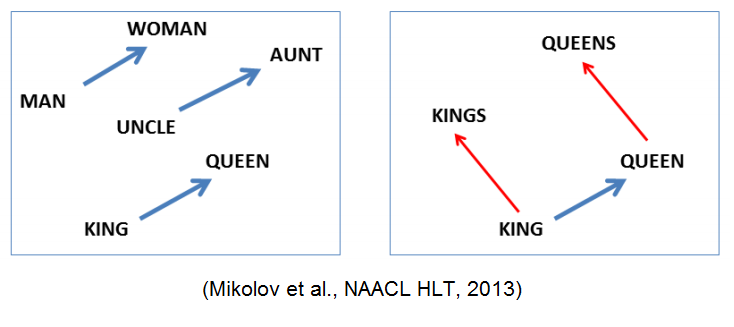

In [32]:
Image('images/analogies.png', width=600)

In [33]:
model_twitter.most_similar(positive=["king", "woman"], negative=["man"])

[('queen', 0.7052316069602966),
 ('prince', 0.6666139364242554),
 ('mother', 0.6436765193939209),
 ('royal', 0.6417251229286194),
 ('father', 0.5952690243721008),
 ('african', 0.5883978009223938),
 ('princess', 0.588217556476593),
 ('called', 0.5842776894569397),
 ('meets', 0.584027886390686),
 ('american', 0.5815179944038391)]

### Порисуем немного

Просто собираем набор слов

In [34]:
# соберем некоторый набор слов
from collections import Counter
from itertools import chain

pop_words = Counter(chain(*data_tok))
some_words = [word for word, count in pop_words.most_common(1000) if len(word) > 2 and not word.isdigit()] 

word_vectors = np.array([model_twitter.get_vector(word) for word in some_words])

Код рисовалки

In [35]:
import bokeh
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
output_notebook()

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

Loading BokehJS ...

### PCA

In [36]:
from sklearn.decomposition import PCA

# map word vectors onto 2d plane with PCA. Use good old sklearn api (fit, transform)
# after that, normalize vectors to make sure they have zero mean and unit variance
word_vectors_pca = PCA(n_components=2).fit_transform(word_vectors)


word_vectors_pca = (word_vectors_pca - word_vectors_pca.mean(0)) / (word_vectors_pca.std(0))

In [37]:
draw_vectors(word_vectors_pca[:, 0], word_vectors_pca[:, 1], token=some_words)

figure(id='p1004', ...)

Сожмем вектора в 2-мерную проекцию. Можно через PCA, но мы воспользуемся более крутым способом __[TSNE](https://distill.pub/2016/misread-tsne/)__.

### TSNE

In [38]:
from sklearn.manifold import TSNE

word_tsne = TSNE(n_jobs=30).fit_transform(word_vectors)
word_tsne = (word_tsne - word_tsne.mean(0)) / word_tsne.std(0)

In [39]:
draw_vectors(word_tsne[:, 0], word_tsne[:, 1], token=some_words)

figure(id='p1053', ...)

### 3.4 Легкие эмбеддинги от Natasha 

In [40]:
from navec import Navec
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar 
path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)

--2024-04-15 10:08:59--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar.1’

navec_hudlit_v1_12B 100%[===================>]  50,56M  19,5MB/s    in 2,6s    

2024-04-15 10:09:01 (19,5 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar.1’ saved [53012480/53012480]



In [41]:
colors = [
 'бежевый',
 'белый',
 'бирюзовый',
 'бордовый',
 'бронза',
 'голубой',
 'горчичный',
 'желтый',
 'зеленый',
 'зеркальный',
 'золотой',
 'коралловый',
 'коричнево-красный',
 'коричневый',
 'красный',
 'кремовый',
 'лазурный',
 'лиловый',
 'малиновый',
 'медь',
 'оливковый',
 'оранжевый',
 'перламутровый',
 'прозрачный',
 'пурпурный',
 'разноцветный',
 'розовый',
 'салатовый',
 'светло-бежевый',
 'светло-желтый',
 'светло-зеленый',
 'светло-коричневый',
 'светло-розовый',
 'светло-серый',
 'светло-синий',
 'серебристый',
 'серый',
 'серый металлик',
 'синий',
 'сиреневый',
 'слоновая кость',
 'темно-бежевый',
 'темно-бордовый',
 'темно-зеленый',
 'темно-коричневый',
 'темно-розовый',
 'темно-серый',
 'темно-синий',
 'фиолетовый',
 'фуксия',
 'хаки',
 'хром',
 'черно-розовый',
 'черно-серый',
 'черный',
 'черный матовый',
 'шоколадный']

In [42]:
import re
from scipy.spatial.distance import cosine

In [43]:
def get_vector(text):
    lst = re.split('-| ', text)
    a = []
    for word in lst:
        if word not in navec:
            continue
        if len(word) > 0:
            a.append(navec[word])
    return sum(v for v in a) / len(lst)

In [44]:
def get_top5(cur_word, lst_words):
    a = [(lst_word, cosine(get_vector(cur_word), get_vector(lst_word))) for lst_word in lst_words]
    return sorted(a, key=lambda tup: tup[1])[:5]

In [45]:
get_top5('металл', colors)

[('медь', 0.41584146634565766),
 ('бронза', 0.5381108146545237),
 ('черный матовый', 0.5876085546356795),
 ('хром', 0.6122124714190229),
 ('прозрачный', 0.6154731461785303)]

In [46]:
get_top5('павлин', colors)

[('разноцветный', 0.7437992012985584),
 ('пурпурный', 0.7507982381598195),
 ('золотой', 0.7635972307645308),
 ('розовый', 0.7691019166510864),
 ('белый', 0.7827041257616476)]

In [47]:
get_top5('волк', colors)

[('серый', 0.5107401956008886),
 ('темно-серый', 0.5533159899306295),
 ('светло-серый', 0.5618065969228838),
 ('черный', 0.598151613544565),
 ('черно-серый', 0.6002673979977022)]

# Ссылки на источники
* [Лекция Deep Learning School](https://www.youtube.com/watch?v=d0oV1MZ_KdE&list=PL0Ks75aof3Ti1GDgeePUkCJWn02c0VDA5&index=1)
* [Сравнение PyMorphy2 и PyMystem3](https://habr.com/ru/post/503420/)
* [Курс Шада](https://github.com/yandexdataschool/nlp_course)
* [Лена Войта Эмбеддинги](https://lena-voita.github.io/nlp_course/word_embeddings.html)
* [Крутая либа для сегментации текста Razdel](https://natasha.github.io/razdel/)
* [Хабр эмбеддинги](https://habr.com/ru/company/ods/blog/329410/)
* [Co-occurrence](https://medium.com/@apargarg99/co-occurrence-matrix-singular-value-decomposition-svd-31b3d3deb305)